<a href="https://colab.research.google.com/github/Olivia-Feldman/DLStockPrectionCNNModel-/blob/Andrew/sources/stock_predictor_rnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Default Imports

In [1]:
import requests
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.ticker as tick
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Set plot stylizations

In [2]:
plt.rcParams.update({'font.size': 16})
plt.rcParams['figure.figsize'] = [12, 8]
plt.style.use('dark_background')

In [3]:
def getStockData(ticker: str, constRange: str='5y'):
    url = "https://query1.finance.yahoo.com/v8/finance/chart/" + ticker + "?region=US&lang=en-US&includePrePost=false&interval=1d&useYfid=true&range=" + constRange + "&corsDomain=finance.yahoo.com&.tsrc=finance"
    x = requests.get(url)
    jsonResponse = x.json()
    timestamps = jsonResponse["chart"]["result"][0]["timestamp"]
    open = jsonResponse["chart"]["result"][0]["indicators"]["quote"][0]["open"]
    high = jsonResponse["chart"]["result"][0]["indicators"]["quote"][0]["high"]
    low = jsonResponse["chart"]["result"][0]["indicators"]["quote"][0]["low"]
    close = jsonResponse["chart"]["result"][0]["indicators"]["quote"][0]["close"]
    volume = jsonResponse["chart"]["result"][0]["indicators"]["quote"][0]["volume"]

    datetimes = list(map(toDatetime, timestamps))

    data = {
        'timestamps' : datetimes,
        'open' : open,
        'high' : high,
        'low' : low,
        'close' : close,
        'volume' : volume
    }

    df = pd.DataFrame(data, columns=['timestamps', 'open', 'high', 'low', 'close', 'volume'])
    return df

def toDatetime(t):
    return datetime.fromtimestamp(t)

In [4]:
ticker = 'QQQ'
df = getStockData(ticker, constRange='10y')


In [5]:
df.tail()

,timestamps,open,high,low,close,volume
2511,2021-04-16 13:30:00,342.149994,342.230011,340.079987,342.010010,40582900
2512,2021-04-19 13:30:00,340.390015,341.579987,336.899994,338.880005,34533100
2513,2021-04-20 13:30:00,338.200012,339.519989,334.380005,336.410004,38081800
2514,2021-04-21 13:30:00,335.089996,339.480011,333.970001,339.290009,36347800
2515,2021-04-22 20:00:03,338.890015,339.899994,334.010010,335.200012,45928730


In [6]:
data_train_copy = df[df['timestamps']<'2020-01-01'].copy()
data_train_copy

,timestamps,open,high,low,close,volume
0,2011-04-25 13:30:00,58.389999,58.520000,58.279999,58.490002,25376800
1,2011-04-26 13:30:00,58.639999,59.029999,58.509998,58.820000,49400000
2,2011-04-27 13:30:00,58.930000,59.290001,58.660000,59.220001,56465500
3,2011-04-28 13:30:00,59.040001,59.230000,58.880001,59.130001,48100000
4,2011-04-29 13:30:00,59.020000,59.290001,58.980000,59.080002,44831200
...,...,...,...,...,...,...
2182,2019-12-24 14:30:00,212.000000,212.089996,211.440002,211.919998,7089000
2183,2019-12-26 14:30:00,212.259995,213.809998,212.229996,213.789993,17067500
2184,2019-12-27 14:30:00,214.539993,214.559998,213.039993,213.610001,18134100
2185,2019-12-30 14:30:00,213.500000,213.630005,211.160004,212.210007,21815500


In [7]:
data_test_copy = df[df['timestamps']>='2020-01-01'].copy()
data_test_copy

,timestamps,open,high,low,close,volume
2187,2020-01-02 14:30:00,214.399994,216.160004,213.979996,216.160004,30969400
2188,2020-01-03 14:30:00,213.300003,215.470001,213.279999,214.179993,27518900
2189,2020-01-06 14:30:00,212.500000,215.589996,212.240005,215.559998,21655300
2190,2020-01-07 14:30:00,215.639999,216.139999,214.850006,215.529999,22139300
2191,2020-01-08 14:30:00,215.500000,218.139999,215.160004,217.149994,26397300
...,...,...,...,...,...,...
2511,2021-04-16 13:30:00,342.149994,342.230011,340.079987,342.010010,40582900
2512,2021-04-19 13:30:00,340.390015,341.579987,336.899994,338.880005,34533100
2513,2021-04-20 13:30:00,338.200012,339.519989,334.380005,336.410004,38081800
2514,2021-04-21 13:30:00,335.089996,339.480011,333.970001,339.290009,36347800


In [8]:
training_data = data_train_copy.drop(['timestamps'], axis=1)
training_data.head()

,open,high,low,close,volume
0,58.389999,58.520000,58.279999,58.490002,25376800
1,58.639999,59.029999,58.509998,58.820000,49400000
2,58.930000,59.290001,58.660000,59.220001,56465500
3,59.040001,59.230000,58.880001,59.130001,48100000
4,59.020000,59.290001,58.980000,59.080002,44831200


In [9]:
scaler = MinMaxScaler()
training_data = scaler.fit_transform(training_data)
training_data.shape

(2187, 5)

In [10]:
time_step = 10

X_train = []
y_train = []
for i in range(time_step, training_data.shape[0]):
    X_train.append(training_data[i-time_step:i])
    y_train.append(training_data[i, 0]) 

In [11]:
X_train, y_train = np.array(X_train), np.array(y_train)
X_train.shape, y_train.shape

((2177, 10, 5), (2177,))

In [12]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

In [13]:
model = Sequential([
    LSTM(
        units=60, 
        activation='relu', 
        return_sequences=True, 
        input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    LSTM(
        units=60, 
        activation='relu', 
        return_sequences=True),
    Dropout(0.2),
    LSTM(
        units=80, 
        activation='relu', 
        return_sequences=True),
    Dropout(0.2),
    LSTM(
        units=120, 
        activation='relu'),
    Dropout(0.2),
    Dense(units=1)
])
# regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
# regressor.add(Dropout(0.2))
# regressor.add(LSTM(units = 50, return_sequences = True))
# regressor.add(Dropout(0.2))
# regressor.add(LSTM(units = 50, return_sequences = True))
# regressor.add(Dropout(0.2))
# regressor.add(LSTM(units = 50))
# regressor.add(Dropout(0.2))
# regressor.add(Dense(units = 1))

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 10, 60)            15840     
_________________________________________________________________
dropout (Dropout)            (None, 10, 60)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 10, 60)            29040     
_________________________________________________________________
dropout_1 (Dropout)          (None, 10, 60)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 10, 80)            45120     
_________________________________________________________________
dropout_2 (Dropout)          (None, 10, 80)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 120)               9

In [15]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [16]:
model.fit(X_train, y_train, epochs=20, batch_size=32)

Epoch 1/20
69/69 [==============================] - 7s 29ms/step - loss: 0.0951
Epoch 2/20
69/69 [==============================] - 2s 28ms/step - loss: 0.0031
Epoch 3/20
69/69 [==============================] - 2s 28ms/step - loss: 0.0026
Epoch 4/20
69/69 [==============================] - 2s 27ms/step - loss: 0.0022
Epoch 5/20
69/69 [==============================] - 2s 27ms/step - loss: 0.0024
Epoch 6/20
69/69 [==============================] - 2s 28ms/step - loss: 0.0029
Epoch 7/20
69/69 [==============================] - 2s 28ms/step - loss: 0.0021
Epoch 8/20
69/69 [==============================] - 2s 27ms/step - loss: 0.0034
Epoch 9/20
69/69 [==============================] - 2s 27ms/step - loss: 0.0018
Epoch 10/20
69/69 [==============================] - 2s 28ms/step - loss: 0.0020
Epoch 11/20
69/69 [==============================] - 2s 28ms/step - loss: 0.0018
Epoch 12/20
69/69 [==============================] - 2s 28ms/step - loss: 0.0019
Epoch 13/20
69/69 [==================

In [17]:
past_60_days = data_train_copy.tail(60)
past_df = past_60_days.append(data_test_copy, ignore_index=True)
past_df = past_df.drop(['timestamps'], axis=1)
past_df.head()

,open,high,low,close,volume
0,188.270004,189.740005,187.910004,188.240005,21216000
1,187.059998,187.860001,185.270004,185.419998,32379300
2,186.990005,188.080002,186.429993,187.229996,20147400
3,187.279999,189.429993,187.119995,188.679993,25177700
4,190.830002,192.630005,190.720001,191.110001,40976700


In [18]:
inputs = scaler.transform(past_df)
inputs

array([[0.83993426, 0.84802846, 0.84593225, 0.84397906, 0.06828252],
       [0.83256156, 0.83651728, 0.82974686, 0.8267587 , 0.12220304],
       [0.83213509, 0.83786434, 0.83685855, 0.83781144, 0.06312101],
       ...,
       [1.75347321, 1.76512365, 1.74391525, 1.74877879, 0.14974702],
       [1.73452356, 1.76487887, 1.74140159, 1.76636553, 0.14137152],
       [1.75767746, 1.7674504 , 1.74164687, 1.74138998, 0.18764894]])

In [19]:
X_test = []
y_test = []
for i in range(time_step, inputs.shape[0]):
    X_test.append(inputs[i-time_step:i])
    y_test.append(inputs[i, 0]) 

In [20]:
X_test, y_test = np.array(X_test), np.array(y_test)
X_test.shape, y_test.shape

((379, 10, 5), (379,))

In [21]:
eval = model.evaluate(x=X_test, y=y_test, batch_size=32)

12/12 [==============================] - 1s 7ms/step - loss: 0.1057


In [22]:
y_pred = model.predict(X_test)
y_pred.shape

(379, 1)

# Reverse Scale

In [23]:
y_pred = y_pred/scaler.scale_[0]
y_test = y_test/scaler.scale_[0]
y_pred.shape, y_test.shape

((379, 1), (379,))

# Vizualization

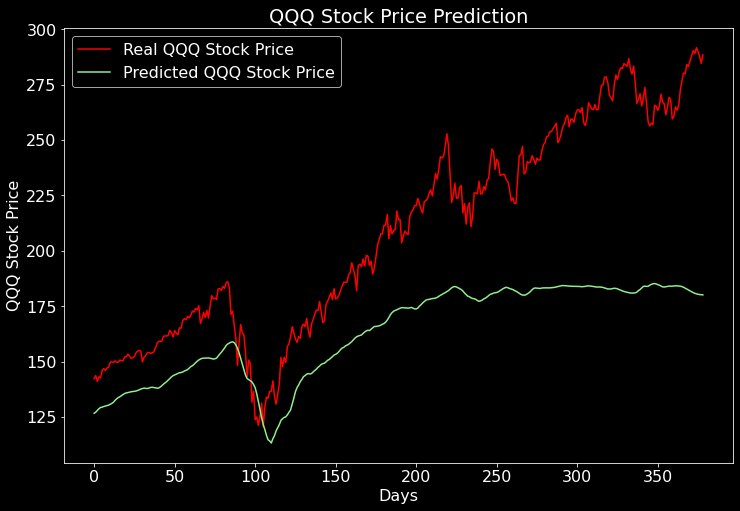

In [24]:
fig = plt.figure()
plt.plot(y_test, color='red', label='Real ' + ticker + ' Stock Price')
plt.plot(y_pred, color='lightgreen', label='Predicted ' + ticker + ' Stock Price')
plt.title(ticker + " Stock Price Prediction")
plt.xlabel('Days')
plt.ylabel(ticker + ' Stock Price')
plt.legend()
plt.show()

In [25]:
accuracy = 0

for i in range(1, y_test.shape[0]):
    price_did_increase = y_test[i] > y_test[i-1]
    model_predicted_increase = y_pred[i] > y_pred[i-1]
    if (price_did_increase == model_predicted_increase):
        accuracy = accuracy + 1

print("Model accuracy: {:.3f}%".format(accuracy / (y_test.shape[0] - 1) * 100))

Model accuracy: 56.878%


In [26]:
#eval = model.evaluate(x=x_test, y=y_test, batch_size=32, verbose=1)